# **Speech Emotion Recognition - (CNN)**

#  Importing


In [5]:
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Utalizing GPU for Feature Extraction and Model Training


In [2]:
import torch
# Check if GPU is available
if torch.cuda.is_available():
    print('GPU is available!')
else:
    print('GPU is not available.')

GPU is available!


In [3]:
# Define a tensor (replace this with your actual tensor creation)
tensor = torch.randn(3, 3)

# Move tensors/models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensor to GPU
tensor = tensor.to(device)

In [32]:
Features = pd.read_csv('features(withSurpriseClass).csv')
print(Features.shape)

(17476, 2377)


In [33]:
# Replace missing values in the Features DataFrame with 0,
# then check if there are any NaN values remaining,
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape


0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(17476, 2377)

In [34]:
# Extract features (X) and labels (Y) from the Features DataFrame:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values


In [35]:
# Initialize a OneHotEncoder, encode the labels (Y), and convert to NumPy array.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Print the categories encoded by the encoder.
encoder.categories_


[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
       dtype=object)]

In [36]:
# Split the dataset with a test size of 15%,
# using stratified sampling based on Y to maintain class balance.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=30, shuffle=True, stratify=Y)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((14854, 2376), (14854, 6), (2622, 2376), (2622, 6))

In [37]:
# Further split the testing set into validation and testing subsets,
# with a validation size of 25% of the original testing set.
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True, stratify=y_test)

x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape


((14854, 2376),
 (1966, 2376),
 (656, 2376),
 (14854, 2376),
 (1966, 2376),
 (656, 2376))

In [38]:
#  sklearn's Standard scaler
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14854, 2376), (14854, 6), (1966, 2376), (1966, 6))

In [39]:
# Expand the dimensions of the training, testing, and validation sets along the third axis.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((14854, 2376, 1), (14854, 6), (1966, 2376, 1), (1966, 6))

In [40]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

In [41]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Define your model
model = Sequential([
    Conv1D(256, 3, activation='relu', input_shape=(2376, 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(256, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.5),
    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Flatten(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Change the output units to 6
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2374, 256)         1024      
                                                                 
 batch_normalization (Batch  (None, 2374, 256)         1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1187, 256)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1185, 256)         196864    
                                                                 
 batch_normalization_1 (Bat  (None, 1185, 256)         1024      
 chNormalization)                                                
                                                        

In [42]:
#Add callbacks function
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks=[learning_rate_reduction]

In [43]:
history=model.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/200
465/465 [==============================] - ETA: 0s - loss: 1.8771 - accuracy: 0.2952

465/465 [==============================] - 39s 58ms/step - loss: 1.8771 - accuracy: 0.2952 - val_loss: 1.6378 - val_accuracy: 0.2820 - lr: 0.0010
Epoch 2/200
464/465 [============================>.] - ETA: 0s - loss: 1.5310 - accuracy: 0.3765

465/465 [==============================] - 27s 59ms/step - loss: 1.5309 - accuracy: 0.3766 - val_loss: 1.4404 - val_accuracy: 0.4070 - lr: 0.0010
Epoch 3/200
464/465 [============================>.] - ETA: 0s - loss: 1.4354 - accuracy: 0.4215

465/465 [==============================] - 26s 57ms/step - loss: 1.4354 - accuracy: 0.4216 - val_loss: 1.4338 - val_accuracy: 0.3857 - lr: 0.0010
Epoch 4/200
464/465 [============================>.] - ETA: 0s - loss: 1.3874 - accuracy: 0.4454

465/465 [==============================] - 26s 56ms/step - loss: 1.3875 - accuracy: 0.4455 - val_loss: 1.3314 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 5/200
464/465 [============================>.] - ETA: 0s - loss: 1.3529 - accuracy: 0.4631

465/465 [==============================] - 27s 57ms/step - loss: 1.3527 - accuracy: 0.4631 - val_loss: 1.3902 - val_accuracy: 0.4329 - lr: 0.0010
Epoch 6/200
464/465 [============================>.] - ETA: 0s - loss: 1.3032 - accuracy: 0.4878

465/465 [==============================] - 26s 56ms/step - loss: 1.3031 - accuracy: 0.4878 - val_loss: 1.5168 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 7/200
464/465 [============================>.] - ETA: 0s - loss: 1.2679 - accuracy: 0.5090

465/465 [==============================] - 27s 57ms/step - loss: 1.2679 - accuracy: 0.5090 - val_loss: 1.2384 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 8/200
464/465 [============================>.] - ETA: 0s - loss: 1.2359 - accuracy: 0.5209

465/465 [==============================] - 26s 56ms/step - loss: 1.2360 - accuracy: 0.5208 - val_loss: 1.2819 - val_accuracy: 0.5030 - lr: 0.0010
Epoch 9/200
464/465 [============================>.] - ETA: 0s - loss: 1.1928 - accuracy: 0.5423

465/465 [==============================] - 27s 57ms/step - loss: 1.1929 - accuracy: 0.5421 - val_loss: 1.3275 - val_accuracy: 0.4604 - lr: 0.0010
Epoch 10/200
464/465 [============================>.] - ETA: 0s - loss: 1.1441 - accuracy: 0.5643

465/465 [==============================] - 27s 57ms/step - loss: 1.1442 - accuracy: 0.5642 - val_loss: 1.1897 - val_accuracy: 0.5290 - lr: 0.0010
Epoch 11/200
464/465 [============================>.] - ETA: 0s - loss: 1.1058 - accuracy: 0.5758

465/465 [==============================] - 27s 57ms/step - loss: 1.1057 - accuracy: 0.5758 - val_loss: 1.1788 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 12/200
464/465 [============================>.] - ETA: 0s - loss: 1.0605 - accuracy: 0.6026

465/465 [==============================] - 26s 57ms/step - loss: 1.0611 - accuracy: 0.6025 - val_loss: 1.1843 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 13/200
464/465 [============================>.] - ETA: 0s - loss: 1.0168 - accuracy: 0.6155

465/465 [==============================] - 27s 57ms/step - loss: 1.0169 - accuracy: 0.6155 - val_loss: 1.1897 - val_accuracy: 0.5168 - lr: 0.0010
Epoch 14/200
464/465 [============================>.] - ETA: 0s - loss: 0.9766 - accuracy: 0.6342

465/465 [==============================] - 26s 57ms/step - loss: 0.9767 - accuracy: 0.6342 - val_loss: 1.0806 - val_accuracy: 0.5945 - lr: 0.0010
Epoch 15/200
464/465 [============================>.] - ETA: 0s - loss: 0.9419 - accuracy: 0.6496

465/465 [==============================] - 27s 57ms/step - loss: 0.9422 - accuracy: 0.6496 - val_loss: 1.1536 - val_accuracy: 0.5777 - lr: 0.0010
Epoch 16/200
464/465 [============================>.] - ETA: 0s - loss: 0.8981 - accuracy: 0.6653

465/465 [==============================] - 26s 57ms/step - loss: 0.8980 - accuracy: 0.6653 - val_loss: 1.1334 - val_accuracy: 0.5534 - lr: 0.0010
Epoch 17/200
464/465 [============================>.] - ETA: 0s - loss: 0.8643 - accuracy: 0.6800

465/465 [==============================] - 27s 58ms/step - loss: 0.8645 - accuracy: 0.6800 - val_loss: 1.1320 - val_accuracy: 0.5777 - lr: 0.0010
Epoch 18/200
464/465 [============================>.] - ETA: 0s - loss: 0.8329 - accuracy: 0.6913

465/465 [==============================] - 27s 57ms/step - loss: 0.8329 - accuracy: 0.6913 - val_loss: 1.0564 - val_accuracy: 0.5884 - lr: 0.0010
Epoch 19/200
464/465 [============================>.] - ETA: 0s - loss: 0.7925 - accuracy: 0.7047

465/465 [==============================] - 26s 57ms/step - loss: 0.7929 - accuracy: 0.7046 - val_loss: 0.9741 - val_accuracy: 0.6387 - lr: 0.0010
Epoch 20/200
464/465 [============================>.] - ETA: 0s - loss: 0.7644 - accuracy: 0.7194

465/465 [==============================] - 27s 58ms/step - loss: 0.7646 - accuracy: 0.7193 - val_loss: 0.9967 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 21/200
464/465 [============================>.] - ETA: 0s - loss: 0.7387 - accuracy: 0.7261

465/465 [==============================] - 26s 57ms/step - loss: 0.7389 - accuracy: 0.7260 - val_loss: 0.9993 - val_accuracy: 0.6387 - lr: 0.0010
Epoch 22/200
464/465 [============================>.] - ETA: 0s - loss: 0.7165 - accuracy: 0.7382

465/465 [==============================] - 27s 58ms/step - loss: 0.7166 - accuracy: 0.7382 - val_loss: 1.0195 - val_accuracy: 0.6204 - lr: 0.0010
Epoch 23/200
464/465 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.7473

465/465 [==============================] - 26s 57ms/step - loss: 0.6870 - accuracy: 0.7471 - val_loss: 1.0155 - val_accuracy: 0.6494 - lr: 0.0010
Epoch 24/200
464/465 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.7588

465/465 [==============================] - 27s 58ms/step - loss: 0.6584 - accuracy: 0.7587 - val_loss: 0.9405 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 25/200
464/465 [============================>.] - ETA: 0s - loss: 0.6385 - accuracy: 0.7639

465/465 [==============================] - 26s 57ms/step - loss: 0.6383 - accuracy: 0.7640 - val_loss: 0.9182 - val_accuracy: 0.6646 - lr: 0.0010
Epoch 26/200
464/465 [============================>.] - ETA: 0s - loss: 0.6252 - accuracy: 0.7711

465/465 [==============================] - 27s 57ms/step - loss: 0.6251 - accuracy: 0.7712 - val_loss: 0.9152 - val_accuracy: 0.6784 - lr: 0.0010
Epoch 27/200
464/465 [============================>.] - ETA: 0s - loss: 0.5945 - accuracy: 0.7792

465/465 [==============================] - 27s 57ms/step - loss: 0.5945 - accuracy: 0.7792 - val_loss: 0.9155 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 28/200
464/465 [============================>.] - ETA: 0s - loss: 0.5803 - accuracy: 0.7885

465/465 [==============================] - 26s 57ms/step - loss: 0.5804 - accuracy: 0.7885 - val_loss: 0.9104 - val_accuracy: 0.6768 - lr: 0.0010
Epoch 29/200
464/465 [============================>.] - ETA: 0s - loss: 0.5826 - accuracy: 0.7860

465/465 [==============================] - 27s 58ms/step - loss: 0.5827 - accuracy: 0.7858 - val_loss: 0.8853 - val_accuracy: 0.6982 - lr: 0.0010
Epoch 30/200
464/465 [============================>.] - ETA: 0s - loss: 0.5474 - accuracy: 0.7983

465/465 [==============================] - 26s 56ms/step - loss: 0.5481 - accuracy: 0.7982 - val_loss: 0.9462 - val_accuracy: 0.6784 - lr: 0.0010
Epoch 31/200
464/465 [============================>.] - ETA: 0s - loss: 0.5479 - accuracy: 0.8023

465/465 [==============================] - 26s 57ms/step - loss: 0.5482 - accuracy: 0.8021 - val_loss: 0.9177 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 32/200
464/465 [============================>.] - ETA: 0s - loss: 0.5299 - accuracy: 0.8070

465/465 [==============================] - 27s 57ms/step - loss: 0.5298 - accuracy: 0.8071 - val_loss: 0.9291 - val_accuracy: 0.6799 - lr: 0.0010
Epoch 33/200
464/465 [============================>.] - ETA: 0s - loss: 0.5107 - accuracy: 0.8161

465/465 [==============================] - 26s 57ms/step - loss: 0.5106 - accuracy: 0.8162 - val_loss: 0.9327 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 34/200
464/465 [============================>.] - ETA: 0s - loss: 0.4975 - accuracy: 0.8236

465/465 [==============================] - 26s 56ms/step - loss: 0.4978 - accuracy: 0.8235 - val_loss: 0.8447 - val_accuracy: 0.7149 - lr: 0.0010
Epoch 35/200
464/465 [============================>.] - ETA: 0s - loss: 0.4981 - accuracy: 0.8176

465/465 [==============================] - 27s 57ms/step - loss: 0.4981 - accuracy: 0.8175 - val_loss: 0.8606 - val_accuracy: 0.7134 - lr: 0.0010
Epoch 36/200
464/465 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.8233

465/465 [==============================] - 26s 57ms/step - loss: 0.4787 - accuracy: 0.8231 - val_loss: 0.8940 - val_accuracy: 0.7210 - lr: 0.0010
Epoch 37/200
464/465 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.8275

465/465 [==============================] - 27s 57ms/step - loss: 0.4604 - accuracy: 0.8275 - val_loss: 0.9447 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 38/200
464/465 [============================>.] - ETA: 0s - loss: 0.4734 - accuracy: 0.8303

465/465 [==============================] - 26s 56ms/step - loss: 0.4735 - accuracy: 0.8302 - val_loss: 0.8949 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 39/200
464/465 [============================>.] - ETA: 0s - loss: 0.4516 - accuracy: 0.8378

465/465 [==============================] - 27s 57ms/step - loss: 0.4515 - accuracy: 0.8378 - val_loss: 0.8888 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 40/200
464/465 [============================>.] - ETA: 0s - loss: 0.4338 - accuracy: 0.8435

465/465 [==============================] - 27s 58ms/step - loss: 0.4344 - accuracy: 0.8434 - val_loss: 0.8233 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 41/200
464/465 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy: 0.8438

465/465 [==============================] - 26s 56ms/step - loss: 0.4279 - accuracy: 0.8437 - val_loss: 0.8281 - val_accuracy: 0.7256 - lr: 0.0010
Epoch 42/200
464/465 [============================>.] - ETA: 0s - loss: 0.4298 - accuracy: 0.8460

465/465 [==============================] - 26s 57ms/step - loss: 0.4300 - accuracy: 0.8459 - val_loss: 0.8652 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 43/200
464/465 [============================>.] - ETA: 0s - loss: 0.4205 - accuracy: 0.8477

465/465 [==============================] - 26s 56ms/step - loss: 0.4209 - accuracy: 0.8475 - val_loss: 0.8489 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 44/200
464/465 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.8541

465/465 [==============================] - 26s 57ms/step - loss: 0.4114 - accuracy: 0.8541 - val_loss: 0.8255 - val_accuracy: 0.7271 - lr: 0.0010
Epoch 45/200
464/465 [============================>.] - ETA: 0s - loss: 0.4004 - accuracy: 0.8549

465/465 [==============================] - 26s 56ms/step - loss: 0.4003 - accuracy: 0.8549 - val_loss: 0.8616 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 46/200
464/465 [============================>.] - ETA: 0s - loss: 0.3986 - accuracy: 0.8576

465/465 [==============================] - 27s 57ms/step - loss: 0.3987 - accuracy: 0.8576 - val_loss: 0.8606 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 47/200
464/465 [============================>.] - ETA: 0s - loss: 0.3908 - accuracy: 0.8609

465/465 [==============================] - 26s 56ms/step - loss: 0.3908 - accuracy: 0.8608 - val_loss: 0.8004 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 48/200
464/465 [============================>.] - ETA: 0s - loss: 0.3753 - accuracy: 0.8640

465/465 [==============================] - 27s 57ms/step - loss: 0.3753 - accuracy: 0.8640 - val_loss: 0.8433 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 49/200
464/465 [============================>.] - ETA: 0s - loss: 0.3748 - accuracy: 0.8603

465/465 [==============================] - 27s 58ms/step - loss: 0.3756 - accuracy: 0.8601 - val_loss: 0.8927 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 50/200
464/465 [============================>.] - ETA: 0s - loss: 0.4771 - accuracy: 0.8278

465/465 [==============================] - 26s 56ms/step - loss: 0.4772 - accuracy: 0.8277 - val_loss: 0.8492 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 51/200
464/465 [============================>.] - ETA: 0s - loss: 0.3839 - accuracy: 0.8609

465/465 [==============================] - 26s 57ms/step - loss: 0.3838 - accuracy: 0.8610 - val_loss: 0.8078 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 52/200
464/465 [============================>.] - ETA: 0s - loss: 0.3581 - accuracy: 0.8682

465/465 [==============================] - 26s 57ms/step - loss: 0.3582 - accuracy: 0.8681 - val_loss: 0.8173 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 53/200
464/465 [============================>.] - ETA: 0s - loss: 0.3569 - accuracy: 0.8732

465/465 [==============================] - 26s 56ms/step - loss: 0.3570 - accuracy: 0.8732 - val_loss: 0.8178 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 54/200
464/465 [============================>.] - ETA: 0s - loss: 0.3505 - accuracy: 0.8740

465/465 [==============================] - 27s 57ms/step - loss: 0.3509 - accuracy: 0.8739 - val_loss: 0.8113 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 55/200
464/465 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8866

465/465 [==============================] - 27s 57ms/step - loss: 0.3263 - accuracy: 0.8866 - val_loss: 0.8380 - val_accuracy: 0.7454 - lr: 0.0010
Epoch 56/200
464/465 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8739

465/465 [==============================] - 27s 57ms/step - loss: 0.3423 - accuracy: 0.8738 - val_loss: 0.8480 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 57/200
464/465 [============================>.] - ETA: 0s - loss: 0.3546 - accuracy: 0.8758

465/465 [==============================] - 26s 57ms/step - loss: 0.3549 - accuracy: 0.8757 - val_loss: 0.8550 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 58/200
464/465 [============================>.] - ETA: 0s - loss: 0.3436 - accuracy: 0.8770

465/465 [==============================] - 27s 57ms/step - loss: 0.3438 - accuracy: 0.8769 - val_loss: 0.7688 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 59/200
464/465 [============================>.] - ETA: 0s - loss: 0.3217 - accuracy: 0.8850

465/465 [==============================] - 26s 57ms/step - loss: 0.3225 - accuracy: 0.8849 - val_loss: 0.7722 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 60/200
464/465 [============================>.] - ETA: 0s - loss: 0.3317 - accuracy: 0.8807

465/465 [==============================] - 26s 57ms/step - loss: 0.3318 - accuracy: 0.8806 - val_loss: 0.7959 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 61/200
464/465 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8848

465/465 [==============================] - 26s 57ms/step - loss: 0.3245 - accuracy: 0.8847 - val_loss: 0.8565 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 62/200
464/465 [============================>.] - ETA: 0s - loss: 0.3182 - accuracy: 0.8872

465/465 [==============================] - 27s 58ms/step - loss: 0.3184 - accuracy: 0.8871 - val_loss: 0.7753 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 63/200
464/465 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8854

465/465 [==============================] - 27s 58ms/step - loss: 0.3249 - accuracy: 0.8854 - val_loss: 0.7703 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 64/200
464/465 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8887

465/465 [==============================] - 27s 58ms/step - loss: 0.3104 - accuracy: 0.8887 - val_loss: 0.8036 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 65/200
464/465 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8905

465/465 [==============================] - 27s 57ms/step - loss: 0.3072 - accuracy: 0.8904 - val_loss: 0.7880 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 66/200
464/465 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8887

465/465 [==============================] - 27s 57ms/step - loss: 0.3125 - accuracy: 0.8885 - val_loss: 0.7886 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 67/200
464/465 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.8881

465/465 [==============================] - 26s 57ms/step - loss: 0.3152 - accuracy: 0.8879 - val_loss: 0.8093 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 68/200
464/465 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8904

465/465 [==============================] - 27s 57ms/step - loss: 0.3063 - accuracy: 0.8903 - val_loss: 0.8040 - val_accuracy: 0.7591 - lr: 0.0010
Epoch 69/200
464/465 [============================>.] - ETA: 0s - loss: 0.2909 - accuracy: 0.8961

465/465 [==============================] - 27s 57ms/step - loss: 0.2909 - accuracy: 0.8961 - val_loss: 0.7467 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 70/200
464/465 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.8984

465/465 [==============================] - 27s 57ms/step - loss: 0.2868 - accuracy: 0.8981 - val_loss: 0.8220 - val_accuracy: 0.7637 - lr: 0.0010
Epoch 71/200
464/465 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8918

465/465 [==============================] - 27s 57ms/step - loss: 0.3080 - accuracy: 0.8917 - val_loss: 0.8275 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 72/200
464/465 [============================>.] - ETA: 0s - loss: 0.3054 - accuracy: 0.8915

465/465 [==============================] - 26s 57ms/step - loss: 0.3053 - accuracy: 0.8915 - val_loss: 0.7974 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 73/200
464/465 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8983

465/465 [==============================] - 26s 57ms/step - loss: 0.2826 - accuracy: 0.8983 - val_loss: 0.8157 - val_accuracy: 0.7744 - lr: 0.0010
Epoch 74/200
464/465 [============================>.] - ETA: 0s - loss: 0.2798 - accuracy: 0.9018

465/465 [==============================] - 26s 57ms/step - loss: 0.2800 - accuracy: 0.9018 - val_loss: 0.7994 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 75/200
464/465 [============================>.] - ETA: 0s - loss: 0.2875 - accuracy: 0.8982

465/465 [==============================] - 26s 57ms/step - loss: 0.2876 - accuracy: 0.8981 - val_loss: 0.7959 - val_accuracy: 0.7637 - lr: 0.0010
Epoch 76/200
464/465 [============================>.] - ETA: 0s - loss: 0.2850 - accuracy: 0.8978

465/465 [==============================] - 27s 57ms/step - loss: 0.2859 - accuracy: 0.8977 - val_loss: 0.7776 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 77/200
464/465 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8972

465/465 [==============================] - 27s 57ms/step - loss: 0.2862 - accuracy: 0.8972 - val_loss: 0.7559 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 78/200
464/465 [============================>.] - ETA: 0s - loss: 0.2648 - accuracy: 0.9044

465/465 [==============================] - 26s 57ms/step - loss: 0.2652 - accuracy: 0.9043 - val_loss: 0.7792 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 79/200
464/465 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.9002

465/465 [==============================] - 26s 56ms/step - loss: 0.2794 - accuracy: 0.9002 - val_loss: 0.7780 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 80/200
464/465 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.9041

465/465 [==============================] - 27s 57ms/step - loss: 0.2756 - accuracy: 0.9039 - val_loss: 0.7628 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 81/200
464/465 [============================>.] - ETA: 0s - loss: 0.2720 - accuracy: 0.9035

465/465 [==============================] - 26s 56ms/step - loss: 0.2729 - accuracy: 0.9033 - val_loss: 0.7974 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 82/200
464/465 [============================>.] - ETA: 0s - loss: 0.2578 - accuracy: 0.9064

465/465 [==============================] - 27s 57ms/step - loss: 0.2577 - accuracy: 0.9064 - val_loss: 0.7942 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 83/200
464/465 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.9098

465/465 [==============================] - 27s 57ms/step - loss: 0.2511 - accuracy: 0.9097 - val_loss: 0.7866 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 84/200
464/465 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.9100

465/465 [==============================] - 26s 57ms/step - loss: 0.2554 - accuracy: 0.9101 - val_loss: 0.7573 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 85/200
464/465 [============================>.] - ETA: 0s - loss: 0.2497 - accuracy: 0.9105

465/465 [==============================] - 27s 58ms/step - loss: 0.2499 - accuracy: 0.9105 - val_loss: 0.7591 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 86/200
464/465 [============================>.] - ETA: 0s - loss: 0.2658 - accuracy: 0.9062

465/465 [==============================] - 26s 57ms/step - loss: 0.2659 - accuracy: 0.9061 - val_loss: 0.8092 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 87/200
464/465 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9110

465/465 [==============================] - 27s 57ms/step - loss: 0.2601 - accuracy: 0.9108 - val_loss: 0.8067 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 88/200
464/465 [============================>.] - ETA: 0s - loss: 0.2623 - accuracy: 0.9065

465/465 [==============================] - 26s 56ms/step - loss: 0.2624 - accuracy: 0.9064 - val_loss: 0.7727 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 89/200
464/465 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.9098

465/465 [==============================] - 27s 57ms/step - loss: 0.2528 - accuracy: 0.9098 - val_loss: 0.7509 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 90/200
464/465 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9141

465/465 [==============================] - 26s 56ms/step - loss: 0.2459 - accuracy: 0.9141 - val_loss: 0.7643 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 91/200
464/465 [============================>.] - ETA: 0s - loss: 0.2415 - accuracy: 0.9155

465/465 [==============================] - 27s 57ms/step - loss: 0.2417 - accuracy: 0.9155 - val_loss: 0.8135 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 92/200
464/465 [============================>.] - ETA: 0s - loss: 0.2465 - accuracy: 0.9119

465/465 [==============================] - 27s 57ms/step - loss: 0.2469 - accuracy: 0.9118 - val_loss: 0.7993 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 93/200
464/465 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9154

465/465 [==============================] - 26s 57ms/step - loss: 0.2416 - accuracy: 0.9154 - val_loss: 0.8265 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 94/200
464/465 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.9120

465/465 [==============================] - 27s 57ms/step - loss: 0.2478 - accuracy: 0.9120 - val_loss: 0.8211 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 95/200
464/465 [============================>.] - ETA: 0s - loss: 0.2377 - accuracy: 0.9166

465/465 [==============================] - 26s 57ms/step - loss: 0.2377 - accuracy: 0.9166 - val_loss: 0.8044 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 96/200
464/465 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.9112

465/465 [==============================] - 27s 57ms/step - loss: 0.2510 - accuracy: 0.9111 - val_loss: 0.8752 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 97/200
464/465 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9159

465/465 [==============================] - 26s 56ms/step - loss: 0.2354 - accuracy: 0.9160 - val_loss: 0.8589 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 98/200
464/465 [============================>.] - ETA: 0s - loss: 0.2305 - accuracy: 0.9209

465/465 [==============================] - 26s 57ms/step - loss: 0.2308 - accuracy: 0.9208 - val_loss: 0.8223 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 99/200
464/465 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9164

465/465 [==============================] - 27s 57ms/step - loss: 0.2362 - accuracy: 0.9163 - val_loss: 0.8074 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 100/200
464/465 [============================>.] - ETA: 0s - loss: 0.2317 - accuracy: 0.9189

465/465 [==============================] - 26s 56ms/step - loss: 0.2320 - accuracy: 0.9188 - val_loss: 0.8322 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 101/200
464/465 [============================>.] - ETA: 0s - loss: 0.2279 - accuracy: 0.9172

465/465 [==============================] - 27s 57ms/step - loss: 0.2278 - accuracy: 0.9172 - val_loss: 0.7933 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 102/200
464/465 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9221

465/465 [==============================] - 26s 57ms/step - loss: 0.2207 - accuracy: 0.9221 - val_loss: 0.8075 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 103/200
464/465 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9271

465/465 [==============================] - 27s 57ms/step - loss: 0.2115 - accuracy: 0.9270 - val_loss: 0.8626 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 104/200
464/465 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9208

465/465 [==============================] - 26s 57ms/step - loss: 0.2248 - accuracy: 0.9207 - val_loss: 0.8039 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 105/200
464/465 [============================>.] - ETA: 0s - loss: 0.2504 - accuracy: 0.9129

465/465 [==============================] - 27s 57ms/step - loss: 0.2505 - accuracy: 0.9129 - val_loss: 0.8154 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 106/200
464/465 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9199

465/465 [==============================] - 27s 58ms/step - loss: 0.2262 - accuracy: 0.9199 - val_loss: 0.8065 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 107/200
464/465 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9235

465/465 [==============================] - 27s 57ms/step - loss: 0.2235 - accuracy: 0.9235 - val_loss: 0.8090 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 108/200
464/465 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9261

465/465 [==============================] - 27s 58ms/step - loss: 0.2159 - accuracy: 0.9261 - val_loss: 0.8228 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 109/200
464/465 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9270

465/465 [==============================] - 26s 57ms/step - loss: 0.2112 - accuracy: 0.9270 - val_loss: 0.7745 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 110/200
464/465 [============================>.] - ETA: 0s - loss: 0.2083 - accuracy: 0.9248

465/465 [==============================] - 27s 57ms/step - loss: 0.2088 - accuracy: 0.9247 - val_loss: 0.8213 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 111/200
464/465 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9244

465/465 [==============================] - 26s 57ms/step - loss: 0.2112 - accuracy: 0.9243 - val_loss: 0.7915 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 112/200
464/465 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9274

465/465 [==============================] - 27s 57ms/step - loss: 0.2039 - accuracy: 0.9272 - val_loss: 0.8044 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 113/200
464/465 [============================>.] - ETA: 0s - loss: 0.2132 - accuracy: 0.9255

465/465 [==============================] - 26s 57ms/step - loss: 0.2132 - accuracy: 0.9255 - val_loss: 0.8233 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 114/200
464/465 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9247

465/465 [==============================] - 26s 56ms/step - loss: 0.2111 - accuracy: 0.9247 - val_loss: 0.8095 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 115/200
464/465 [============================>.] - ETA: 0s - loss: 0.2099 - accuracy: 0.9256

465/465 [==============================] - 27s 57ms/step - loss: 0.2100 - accuracy: 0.9256 - val_loss: 0.7994 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 116/200
464/465 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9260

465/465 [==============================] - 26s 56ms/step - loss: 0.2140 - accuracy: 0.9259 - val_loss: 0.8079 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 117/200
464/465 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9281

465/465 [==============================] - 27s 58ms/step - loss: 0.2063 - accuracy: 0.9281 - val_loss: 0.7957 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 118/200
464/465 [============================>.] - ETA: 0s - loss: 0.2002 - accuracy: 0.9301

465/465 [==============================] - 26s 56ms/step - loss: 0.2002 - accuracy: 0.9301 - val_loss: 0.7772 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 119/200
464/465 [============================>.] - ETA: 0s - loss: 0.2009 - accuracy: 0.9302

465/465 [==============================] - 27s 57ms/step - loss: 0.2014 - accuracy: 0.9301 - val_loss: 0.7872 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 120/200
464/465 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9307

465/465 [==============================] - 27s 58ms/step - loss: 0.1933 - accuracy: 0.9306 - val_loss: 0.7787 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 121/200
464/465 [============================>.] - ETA: 0s - loss: 0.2116 - accuracy: 0.9275

465/465 [==============================] - 26s 56ms/step - loss: 0.2116 - accuracy: 0.9275 - val_loss: 0.7781 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 122/200
464/465 [============================>.] - ETA: 0s - loss: 0.2101 - accuracy: 0.9273

465/465 [==============================] - 27s 58ms/step - loss: 0.2101 - accuracy: 0.9273 - val_loss: 0.7679 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 123/200
464/465 [============================>.] - ETA: 0s - loss: 0.1970 - accuracy: 0.9320

465/465 [==============================] - 26s 57ms/step - loss: 0.1970 - accuracy: 0.9319 - val_loss: 0.7738 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 124/200
464/465 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9312

465/465 [==============================] - 27s 57ms/step - loss: 0.1962 - accuracy: 0.9311 - val_loss: 0.7382 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 125/200
464/465 [============================>.] - ETA: 0s - loss: 0.1896 - accuracy: 0.9329

465/465 [==============================] - 26s 57ms/step - loss: 0.1901 - accuracy: 0.9329 - val_loss: 0.7518 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 126/200
464/465 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9335

465/465 [==============================] - 27s 57ms/step - loss: 0.1977 - accuracy: 0.9335 - val_loss: 0.7729 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 127/200
464/465 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9285

465/465 [==============================] - 27s 58ms/step - loss: 0.2055 - accuracy: 0.9285 - val_loss: 0.7491 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 128/200
464/465 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9306

465/465 [==============================] - 26s 57ms/step - loss: 0.1946 - accuracy: 0.9305 - val_loss: 0.7661 - val_accuracy: 0.8323 - lr: 0.0010
Epoch 129/200
464/465 [============================>.] - ETA: 0s - loss: 0.1875 - accuracy: 0.9316

465/465 [==============================] - 27s 58ms/step - loss: 0.1879 - accuracy: 0.9316 - val_loss: 0.7885 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 130/200
464/465 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9261

465/465 [==============================] - 27s 57ms/step - loss: 0.2054 - accuracy: 0.9260 - val_loss: 0.7618 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 131/200
464/465 [============================>.] - ETA: 0s - loss: 0.1853 - accuracy: 0.9361

465/465 [==============================] - 27s 58ms/step - loss: 0.1853 - accuracy: 0.9361 - val_loss: 0.8394 - val_accuracy: 0.8064 - lr: 0.0010
Epoch 132/200
464/465 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9331

465/465 [==============================] - 26s 56ms/step - loss: 0.1856 - accuracy: 0.9331 - val_loss: 0.8254 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 133/200
464/465 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9319

465/465 [==============================] - 27s 57ms/step - loss: 0.1886 - accuracy: 0.9319 - val_loss: 0.7837 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 134/200
464/465 [============================>.] - ETA: 0s - loss: 0.1991 - accuracy: 0.9329

465/465 [==============================] - 27s 58ms/step - loss: 0.1991 - accuracy: 0.9329 - val_loss: 0.8004 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 135/200
464/465 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9365

465/465 [==============================] - 26s 56ms/step - loss: 0.1847 - accuracy: 0.9365 - val_loss: 0.7697 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 136/200
464/465 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9369

465/465 [==============================] - 26s 57ms/step - loss: 0.1805 - accuracy: 0.9369 - val_loss: 0.7452 - val_accuracy: 0.8262 - lr: 0.0010
Epoch 137/200
464/465 [============================>.] - ETA: 0s - loss: 0.1741 - accuracy: 0.9411

465/465 [==============================] - 26s 57ms/step - loss: 0.1744 - accuracy: 0.9410 - val_loss: 0.8031 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 138/200
464/465 [============================>.] - ETA: 0s - loss: 0.1916 - accuracy: 0.9355

465/465 [==============================] - 26s 57ms/step - loss: 0.1916 - accuracy: 0.9356 - val_loss: 0.7939 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 139/200
464/465 [============================>.] - ETA: 0s - loss: 0.1862 - accuracy: 0.9348

465/465 [==============================] - 26s 57ms/step - loss: 0.1862 - accuracy: 0.9348 - val_loss: 0.8279 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 140/200
464/465 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9315

465/465 [==============================] - 27s 57ms/step - loss: 0.1928 - accuracy: 0.9315 - val_loss: 0.8062 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 141/200
464/465 [============================>.] - ETA: 0s - loss: 0.1778 - accuracy: 0.9397

465/465 [==============================] - 27s 58ms/step - loss: 0.1777 - accuracy: 0.9397 - val_loss: 0.7924 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 142/200
464/465 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9334

465/465 [==============================] - 27s 58ms/step - loss: 0.1839 - accuracy: 0.9334 - val_loss: 0.8058 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 143/200
464/465 [============================>.] - ETA: 0s - loss: 0.1890 - accuracy: 0.9339

465/465 [==============================] - 26s 56ms/step - loss: 0.1892 - accuracy: 0.9338 - val_loss: 0.7653 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 144/200
464/465 [============================>.] - ETA: 0s - loss: 0.1821 - accuracy: 0.9362

465/465 [==============================] - 27s 57ms/step - loss: 0.1825 - accuracy: 0.9360 - val_loss: 0.8059 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 145/200
464/465 [============================>.] - ETA: 0s - loss: 0.1852 - accuracy: 0.9362

465/465 [==============================] - 26s 57ms/step - loss: 0.1852 - accuracy: 0.9362 - val_loss: 0.7630 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 146/200
464/465 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9354

465/465 [==============================] - 27s 57ms/step - loss: 0.1859 - accuracy: 0.9353 - val_loss: 0.8206 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 147/200
464/465 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9290

465/465 [==============================] - 26s 56ms/step - loss: 0.2033 - accuracy: 0.9289 - val_loss: 0.7636 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 148/200
464/465 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9391

465/465 [==============================] - 27s 58ms/step - loss: 0.1748 - accuracy: 0.9391 - val_loss: 0.7435 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 149/200
464/465 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9395

465/465 [==============================] - 27s 57ms/step - loss: 0.1679 - accuracy: 0.9395 - val_loss: 0.7534 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 150/200
464/465 [============================>.] - ETA: 0s - loss: 0.1711 - accuracy: 0.9394

465/465 [==============================] - 26s 57ms/step - loss: 0.1712 - accuracy: 0.9393 - val_loss: 0.7596 - val_accuracy: 0.8262 - lr: 0.0010
Epoch 151/200
464/465 [============================>.] - ETA: 0s - loss: 0.1714 - accuracy: 0.9409

465/465 [==============================] - 26s 57ms/step - loss: 0.1719 - accuracy: 0.9408 - val_loss: 0.8047 - val_accuracy: 0.8323 - lr: 0.0010
Epoch 152/200
464/465 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.9345

465/465 [==============================] - 26s 57ms/step - loss: 0.1869 - accuracy: 0.9344 - val_loss: 0.7917 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 153/200
464/465 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9414

465/465 [==============================] - 27s 57ms/step - loss: 0.1659 - accuracy: 0.9414 - val_loss: 0.7885 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 154/200
464/465 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9378

465/465 [==============================] - 27s 57ms/step - loss: 0.1786 - accuracy: 0.9378 - val_loss: 0.8406 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 155/200
464/465 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9393

465/465 [==============================] - 27s 59ms/step - loss: 0.1728 - accuracy: 0.9392 - val_loss: 0.8140 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 156/200
464/465 [============================>.] - ETA: 0s - loss: 0.1608 - accuracy: 0.9434

465/465 [==============================] - 26s 56ms/step - loss: 0.1618 - accuracy: 0.9432 - val_loss: 0.8129 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 157/200
464/465 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9359

465/465 [==============================] - 27s 57ms/step - loss: 0.1802 - accuracy: 0.9358 - val_loss: 0.7928 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 158/200
464/465 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9413

465/465 [==============================] - 26s 56ms/step - loss: 0.1683 - accuracy: 0.9414 - val_loss: 0.8090 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 159/200
464/465 [============================>.] - ETA: 0s - loss: 0.1724 - accuracy: 0.9395

465/465 [==============================] - 27s 57ms/step - loss: 0.1723 - accuracy: 0.9395 - val_loss: 0.8197 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 160/200
464/465 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9426

465/465 [==============================] - 26s 56ms/step - loss: 0.1669 - accuracy: 0.9426 - val_loss: 0.8404 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 161/200
464/465 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9435

465/465 [==============================] - 27s 57ms/step - loss: 0.1666 - accuracy: 0.9435 - val_loss: 0.8355 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 162/200
464/465 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9449

465/465 [==============================] - 27s 57ms/step - loss: 0.1600 - accuracy: 0.9449 - val_loss: 0.7923 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 163/200
464/465 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9437

465/465 [==============================] - 26s 56ms/step - loss: 0.1666 - accuracy: 0.9434 - val_loss: 0.8245 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 164/200
464/465 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9401

465/465 [==============================] - 27s 57ms/step - loss: 0.1704 - accuracy: 0.9399 - val_loss: 0.8145 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 165/200
464/465 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9446

465/465 [==============================] - 26s 57ms/step - loss: 0.1581 - accuracy: 0.9446 - val_loss: 0.8285 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 166/200
464/465 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9459

465/465 [==============================] - 26s 57ms/step - loss: 0.1600 - accuracy: 0.9458 - val_loss: 0.7974 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 167/200
464/465 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9429

465/465 [==============================] - 26s 56ms/step - loss: 0.1631 - accuracy: 0.9428 - val_loss: 0.8258 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 168/200
464/465 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9445

465/465 [==============================] - 27s 57ms/step - loss: 0.1582 - accuracy: 0.9445 - val_loss: 0.8573 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 169/200
464/465 [============================>.] - ETA: 0s - loss: 0.1625 - accuracy: 0.9443

465/465 [==============================] - 26s 57ms/step - loss: 0.1625 - accuracy: 0.9443 - val_loss: 0.8473 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 170/200
464/465 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9428

465/465 [==============================] - 27s 57ms/step - loss: 0.1679 - accuracy: 0.9428 - val_loss: 0.8280 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 171/200
464/465 [============================>.] - ETA: 0s - loss: 0.1618 - accuracy: 0.9442

465/465 [==============================] - 27s 57ms/step - loss: 0.1628 - accuracy: 0.9441 - val_loss: 0.8253 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 172/200
464/465 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9415

465/465 [==============================] - 27s 57ms/step - loss: 0.1667 - accuracy: 0.9415 - val_loss: 0.8291 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 173/200
464/465 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9469

465/465 [==============================] - 26s 57ms/step - loss: 0.1550 - accuracy: 0.9468 - val_loss: 0.7863 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 174/200
464/465 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9447

465/465 [==============================] - 26s 57ms/step - loss: 0.1641 - accuracy: 0.9446 - val_loss: 0.7825 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 175/200
464/465 [============================>.] - ETA: 0s - loss: 0.1653 - accuracy: 0.9419

465/465 [==============================] - 26s 57ms/step - loss: 0.1652 - accuracy: 0.9420 - val_loss: 0.8130 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 176/200
464/465 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9484

465/465 [==============================] - 26s 57ms/step - loss: 0.1486 - accuracy: 0.9484 - val_loss: 0.8285 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 177/200
464/465 [============================>.] - ETA: 0s - loss: 0.1527 - accuracy: 0.9477

465/465 [==============================] - 26s 57ms/step - loss: 0.1529 - accuracy: 0.9477 - val_loss: 0.7956 - val_accuracy: 0.8262 - lr: 0.0010
Epoch 178/200
464/465 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9462

465/465 [==============================] - 27s 57ms/step - loss: 0.1568 - accuracy: 0.9462 - val_loss: 0.8078 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 179/200
464/465 [============================>.] - ETA: 0s - loss: 0.1575 - accuracy: 0.9455

465/465 [==============================] - 27s 57ms/step - loss: 0.1575 - accuracy: 0.9455 - val_loss: 0.8626 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 180/200
464/465 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9457

465/465 [==============================] - 26s 57ms/step - loss: 0.1594 - accuracy: 0.9457 - val_loss: 0.8446 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 181/200
464/465 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9421

465/465 [==============================] - 26s 56ms/step - loss: 0.1656 - accuracy: 0.9420 - val_loss: 0.8673 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 182/200
464/465 [============================>.] - ETA: 0s - loss: 0.1512 - accuracy: 0.9471

465/465 [==============================] - 27s 58ms/step - loss: 0.1512 - accuracy: 0.9471 - val_loss: 0.8536 - val_accuracy: 0.8064 - lr: 0.0010
Epoch 183/200
464/465 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9420

465/465 [==============================] - 26s 56ms/step - loss: 0.1712 - accuracy: 0.9420 - val_loss: 0.8455 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 184/200
464/465 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9475

465/465 [==============================] - 26s 57ms/step - loss: 0.1564 - accuracy: 0.9474 - val_loss: 0.8592 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 185/200
464/465 [============================>.] - ETA: 0s - loss: 0.1604 - accuracy: 0.9431

465/465 [==============================] - 26s 56ms/step - loss: 0.1605 - accuracy: 0.9430 - val_loss: 0.8074 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 186/200
464/465 [============================>.] - ETA: 0s - loss: 0.1528 - accuracy: 0.9468

465/465 [==============================] - 26s 57ms/step - loss: 0.1528 - accuracy: 0.9468 - val_loss: 0.8187 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 187/200
464/465 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.9518

465/465 [==============================] - 26s 56ms/step - loss: 0.1399 - accuracy: 0.9519 - val_loss: 0.8421 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 188/200
464/465 [============================>.] - ETA: 0s - loss: 0.1436 - accuracy: 0.9521

465/465 [==============================] - 26s 57ms/step - loss: 0.1435 - accuracy: 0.9521 - val_loss: 0.8083 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 189/200
464/465 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9489

465/465 [==============================] - 27s 57ms/step - loss: 0.1535 - accuracy: 0.9488 - val_loss: 0.8105 - val_accuracy: 0.8323 - lr: 0.0010
Epoch 190/200
464/465 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9479

465/465 [==============================] - 26s 57ms/step - loss: 0.1499 - accuracy: 0.9478 - val_loss: 0.8088 - val_accuracy: 0.8262 - lr: 0.0010
Epoch 191/200
464/465 [============================>.] - ETA: 0s - loss: 0.1567 - accuracy: 0.9452

465/465 [==============================] - 27s 58ms/step - loss: 0.1566 - accuracy: 0.9452 - val_loss: 0.7961 - val_accuracy: 0.8216 - lr: 0.0010
Epoch 192/200
464/465 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9479

465/465 [==============================] - 26s 57ms/step - loss: 0.1503 - accuracy: 0.9479 - val_loss: 0.8098 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 193/200
464/465 [============================>.] - ETA: 0s - loss: 0.1553 - accuracy: 0.9440

465/465 [==============================] - 27s 57ms/step - loss: 0.1553 - accuracy: 0.9440 - val_loss: 0.8415 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 194/200
464/465 [============================>.] - ETA: 0s - loss: 0.1489 - accuracy: 0.9505

465/465 [==============================] - 26s 57ms/step - loss: 0.1489 - accuracy: 0.9505 - val_loss: 0.7904 - val_accuracy: 0.8308 - lr: 0.0010
Epoch 195/200
464/465 [============================>.] - ETA: 0s - loss: 0.1682 - accuracy: 0.9430

465/465 [==============================] - 26s 57ms/step - loss: 0.1688 - accuracy: 0.9430 - val_loss: 0.8402 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 196/200
464/465 [============================>.] - ETA: 0s - loss: 0.1608 - accuracy: 0.9444

465/465 [==============================] - 27s 57ms/step - loss: 0.1610 - accuracy: 0.9443 - val_loss: 0.7884 - val_accuracy: 0.8216 - lr: 0.0010
Epoch 197/200
464/465 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9499

465/465 [==============================] - 26s 57ms/step - loss: 0.1438 - accuracy: 0.9499 - val_loss: 0.8005 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 198/200
464/465 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9516

465/465 [==============================] - 26s 57ms/step - loss: 0.1356 - accuracy: 0.9516 - val_loss: 0.8465 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 199/200
464/465 [============================>.] - ETA: 0s - loss: 0.1403 - accuracy: 0.9520

465/465 [==============================] - 26s 56ms/step - loss: 0.1403 - accuracy: 0.9519 - val_loss: 0.7934 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 200/200
464/465 [============================>.] - ETA: 0s - loss: 0.1518 - accuracy: 0.9467

465/465 [==============================] - 26s 57ms/step - loss: 0.1518 - accuracy: 0.9467 - val_loss: 0.7889 - val_accuracy: 0.8232 - lr: 0.0010


In [45]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

62/62 [==============================] - 2s 27ms/step - loss: 0.7220 - accuracy: 0.8367
Accuracy of our model on test data :  83.672434091568 %


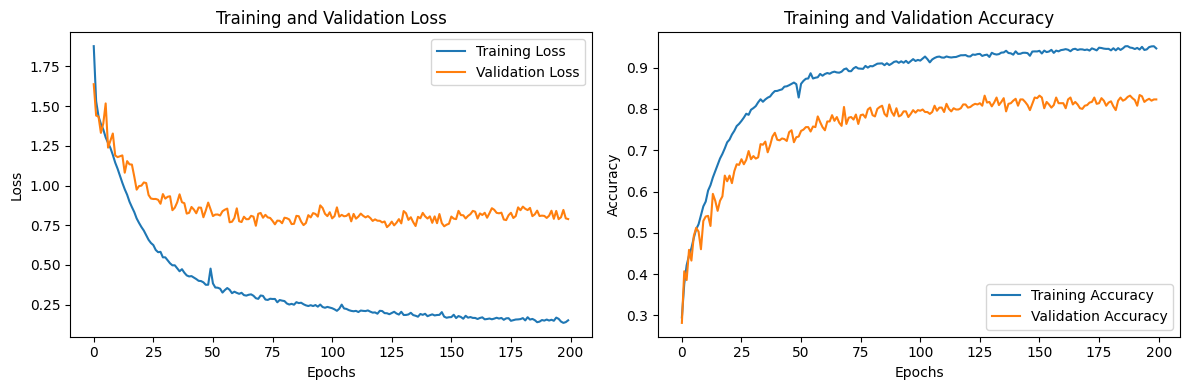

31/31 [==============================] - 3s 56ms/step - loss: 0.7220 - accuracy: 0.8367
Test Loss: 0.7220
Test Accuracy: 0.8367


In [51]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=64)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [55]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=64)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 [==============================] - 1s 34ms/step - loss: 0.7220 - accuracy: 0.8367
Test Loss: 0.7220
Test Accuracy: 0.8367


In [56]:
# Predict on the test data
y_pred = model.predict(x_test)


62/62 [==============================] - 1s 16ms/step


In [61]:
# Convert string labels to numerical values
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Predicted Labels'] = label_encoder.fit_transform(df['Predicted Labels'])
df['Actual Labels'] = label_encoder.transform(df['Actual Labels'])

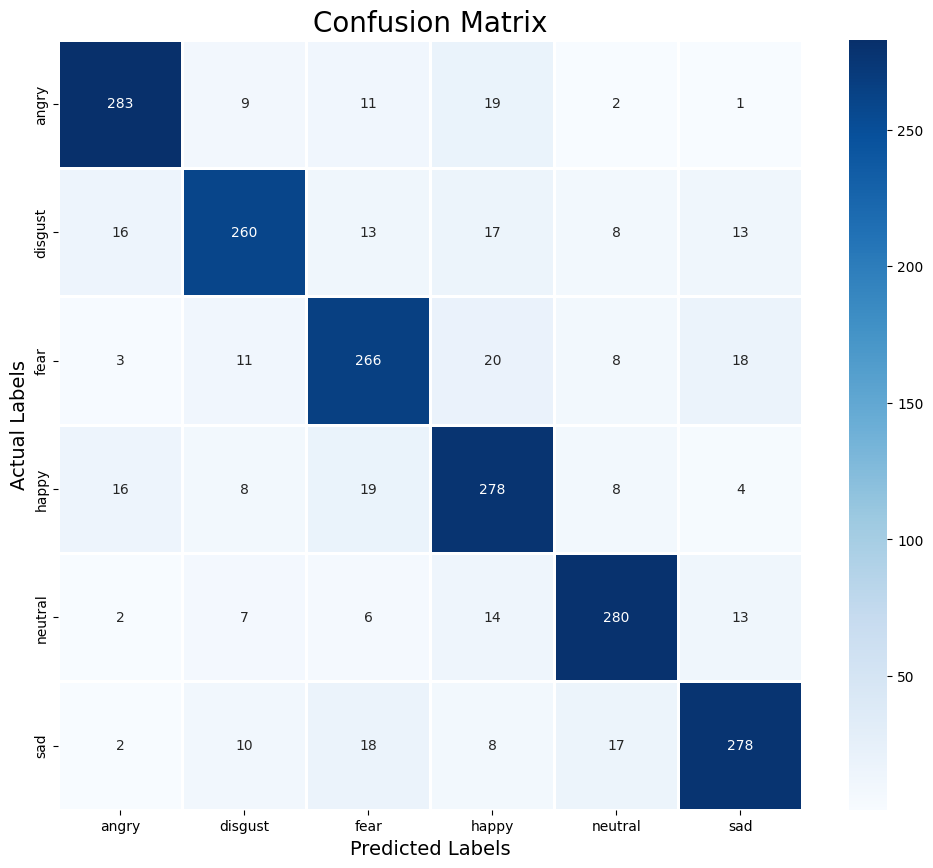

In [59]:
# Generate and display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [60]:
# Print classification report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       325
           1       0.85      0.80      0.82       327
           2       0.80      0.82      0.81       326
           3       0.78      0.83      0.81       333
           4       0.87      0.87      0.87       322
           5       0.85      0.83      0.84       333

    accuracy                           0.84      1966
   macro avg       0.84      0.84      0.84      1966
weighted avg       0.84      0.84      0.84      1966

